<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM_GRU/LSTM_GRU_Cu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 4.81 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Jul 19 10:49:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Cu'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM_GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 8.1MB/s 
     |████████████████████████████████| 174kB 54.4MB/s 
     |████████████████████████████████| 143kB 58.5MB/s 
     |████████████████████████████████| 143kB 57.8MB/s 
     |████████████████████████████████| 102kB 13.8MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(LSTM(units=64, activation=config.activation, return_sequences=True, input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(GRU(units=64, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 3
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: hgiundb1
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM_GRU/sweeps/hgiundb1


In [16]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: lexlw7n5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 7s 189ms/step - loss: 0.2034 - mean_squared_error: 0.2034 - mean_absolute_error: 0.4006 - val_loss: 0.0768 - val_mean_squared_error: 0.0768 - val_mean_absolute_error: 0.2231
Epoch 2/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0542 - mean_squared_error: 0.0542 - mean_absolute_error: 0.1857 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1242
Epoch 3/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0686 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1243
Epoch 4/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0628 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1169
Epoch 5/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0045 - mean_squared_error: 0.

epoch,199
loss,0.00117
mean_squared_error,0.00117
mean_absolute_error,0.02672
val_loss,0.00915
val_mean_squared_error,0.00915
val_mean_absolute_error,0.07518
_runtime,50
_timestamp,1626642441
_step,199
best_val_loss,0.00913


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qwnwq6ak with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 13s 233ms/step - loss: 0.1876 - mean_squared_error: 0.1876 - mean_absolute_error: 0.3759 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1282
Epoch 2/100
32/32 [==============================] - 6s 190ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0670 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1032
Epoch 3/100
32/32 [==============================] - 6s 190ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0485 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1056
Epoch 4/100
32/32 [==============================] - 6s 185ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0449 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1062
Epoch 5/100
32/32 [==============================] - 6s 190ms/step - loss: 0.0033 - mean_sq

epoch,99
loss,0.00149
mean_squared_error,0.00149
mean_absolute_error,0.02938
val_loss,0.01131
val_mean_squared_error,0.01131
val_mean_absolute_error,0.08163
_runtime,629
_timestamp,1626643087
_step,99
best_val_loss,0.01038


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▅▄▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▁▂▂▁▁
val_mean_squared_error,█▅▅▅▅▄▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▁▂▂▁▁
val_mean_absolute_error,█▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 57r9mxql with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 7s 92ms/step - loss: 0.1121 - mean_squared_error: 0.1121 - mean_absolute_error: 0.2268 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1145
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0712 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1173
Epoch 3/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0740 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1058
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0674 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1151
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0069 - mean_squared_

epoch,99
loss,0.00118
mean_squared_error,0.00118
mean_absolute_error,0.02563
val_loss,0.006
val_mean_squared_error,0.006
val_mean_absolute_error,0.05904
_runtime,37
_timestamp,1626643139
_step,99
best_val_loss,0.006


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇█▅▄▄▃▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▃▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁
val_mean_squared_error,▇▇█▅▄▄▃▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▃▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,▇▆█▅▅▄▄▅▄▄▄▃▃▃▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ztivsb0m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 6s 94ms/step - loss: 0.0781 - mean_squared_error: 0.0781 - mean_absolute_error: 0.1955 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0857
Epoch 2/50
16/16 [==============================] - 1s 50ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0467 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0852
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0354 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0858
Epoch 4/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0338 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0894
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0019 - mean_squared_error

epoch,49
loss,0.00106
mean_squared_error,0.00106
mean_absolute_error,0.02533
val_loss,0.00728
val_mean_squared_error,0.00728
val_mean_absolute_error,0.06758
_runtime,24
_timestamp,1626643183
_step,49
best_val_loss,0.00674


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▆▆▇█▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂
val_mean_squared_error,▇▆▆▇█▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂
val_mean_absolute_error,▆▆▆▇█▆▆▆▆▅▆▅▅▅▄▅▅▄▄▄▃▃▃▃▃▃▂▂▃▂▂▂▃▁▂▂▁▁▁▂
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ct9at6sj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 6s 187ms/step - loss: 0.5685 - mean_squared_error: 0.5685 - mean_absolute_error: 0.5499 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1096
Epoch 2/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0730 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1257
Epoch 3/200
8/8 [==============================] - 0s 15ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0867 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1367
Epoch 4/200
8/8 [==============================] - 0s 15ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0980 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1172
Epoch 5/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0124 - mean_squared_error: 0.

epoch,51
loss,0.00398
mean_squared_error,0.00398
mean_absolute_error,0.05174
val_loss,0.00891
val_mean_squared_error,0.00891
val_mean_absolute_error,0.07439
_runtime,19
_timestamp,1626643212
_step,51
best_val_loss,0.00707


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▅▆█▅▇▇▅██▅▅▃▆▅▃▂█▃▃▃▃▃▄▂▂▂▁▂▂▁▂▂▁▁▂▁▂▁▁▂
val_mean_squared_error,▅▆█▅▇▇▅██▅▅▃▆▅▃▂█▃▃▃▃▃▄▂▂▂▁▂▂▁▂▂▁▁▂▁▂▁▁▂
val_mean_absolute_error,▅▇█▆▇▇▆██▅▅▄▆▆▃▃█▃▄▃▃▃▄▃▂▂▂▂▂▁▂▃▁▁▂▁▂▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ccfbsp33 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 7s 96ms/step - loss: 0.1171 - mean_squared_error: 0.1171 - mean_absolute_error: 0.2679 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1098
Epoch 2/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0734 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1194
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0561 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1012
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0423 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0993
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0022 - mean_squared_error

epoch,49
loss,0.00133
mean_squared_error,0.00133
mean_absolute_error,0.02847
val_loss,0.01127
val_mean_squared_error,0.01127
val_mean_absolute_error,0.08293
_runtime,25
_timestamp,1626643277
_step,49
best_val_loss,0.01127


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▅▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
val_mean_squared_error,▆█▅▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
val_mean_absolute_error,▆█▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: bh5h9b4n with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 13s 235ms/step - loss: 0.1478 - mean_squared_error: 0.1478 - mean_absolute_error: 0.3066 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1168
Epoch 2/100
32/32 [==============================] - 6s 198ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0467 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1061
Epoch 3/100
32/32 [==============================] - 6s 204ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0470 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1051
Epoch 4/100
32/32 [==============================] - 6s 196ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0427 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1071
Epoch 5/100
32/32 [==============================] - 6s 197ms/step - loss: 0.0029 - mean_sq

wandb: Ctrl + C detected. Stopping sweep.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fe19725e890>> (for post_run_cell):


KeyboardInterrupt: ignored

# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [10]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 64,
    'learning_rate': 0.005,
    'dropout': 0.1,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [12]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(LSTM(units=64, activation=best_config['activation'], return_sequences=True, input_shape=(window_len, 1)))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(GRU(units=64, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 3
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  41921


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            16896     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
gru (GRU)                    (None, 64)                24960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 41,921
Trainable params: 41,921
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
20/20 [==============================] - 25s 104ms/step - loss: 0.4437
Epoch 2/200
20/20 [==============================] - 2s 104ms/step - loss: 0.0043
Epoch 3/200
20/20 [==============================] - 2s 106ms/step - loss: 0.0030
Epoch 4/200
20/20 [==============================] - 2s 108ms/step - loss: 0.0030
Epoch 5/200
20/20 [==============================] - 2s 101ms/step - loss: 0.0029
Epoch 6/200
20/20 [==============================] - 2s 107ms/step - loss: 0.0027
Epoch 7/200
20/20 [==============================] - 2s 107ms/step - loss: 0.0026
Epoch 8/200
20/20 [==============================] - 2s 109ms/step - loss: 0.0025
Epoch 9/200
20/20 [==============================] - 2s 105ms/step - loss: 0.0024
Epoch 10/200
20/20 [==============================] - 2s 112ms/step - loss: 0.0024
Epoch 11/200
20/20 [==============================] - 2s 109ms/step - loss: 0.0021
Epoch 12/200
20/20 [==============================] - 2s 104ms/step - loss: 0.0023
Epoch 13/200

In [15]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

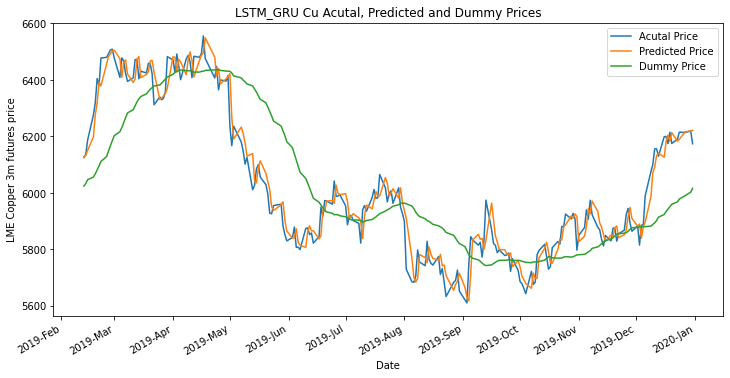

In [16]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

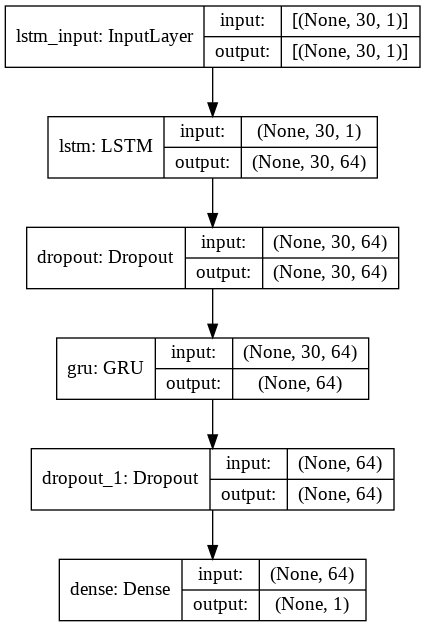

In [17]:
plot_model(model, show_shapes=True, expand_nested=True)

In [18]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0030875992427958363
RMSE:  0.05556616994895218
MAE:  0.0432077097567441
Dummy MSE:  0.02889885289047612
Dummy RMSE:  0.16999662611497945
Dummy MAE:  0.13217330779902475


In [19]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_GRU_Cu/assets
